# 🍄 Mushroom - Edible or Poisonous

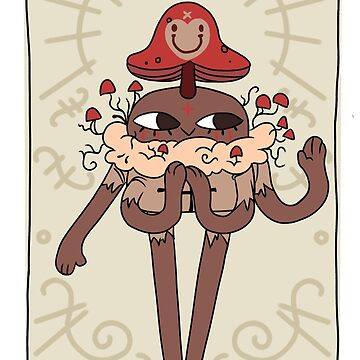

## ⚙️ Initial Configuration

Library Imports

In [17]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [18]:
df = pd.read_csv('./mushroom.csv')
df.shape

(61069, 21)

## 🔎 EDA

* The target variable is **class**
* Looks like there are some ```NaN``` attributes to be dealt with
* There are plenty of features to use
* Some of the encoding is non-intuitive and will need to be looked up

In [19]:
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


### 🎯 Target

In [20]:
target = 'class'

The target variable is quite evenly-distributed with 5.5% more mushrooms in the dataset being ```poisonous```.

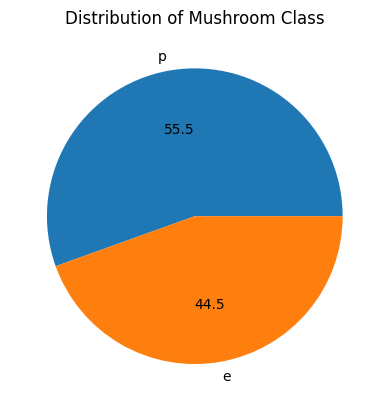

In [21]:
plt.pie(df[target].value_counts(), labels = df[target].value_counts().keys(), autopct='%1.1f')
plt.title("Distribution of Mushroom Class")
plt.show()

### 🎩 Cap Variables

#### Cap Diameter

There's a whole 'nother cluster of high-diameter outliers that are exclusively ```edible```. This data would be of great value if it could be either added into it's own class, or leveraged with clustering algorithms.

It's worthy to note that even with the cluster of all outlier values over ```35``` being removed, the **cap diameter** still has a slightly higher range of values.

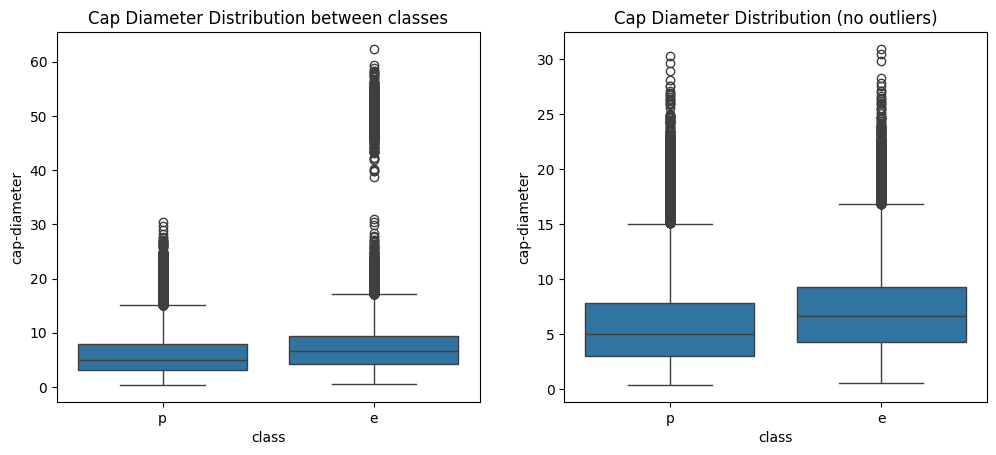

In [22]:
df_cap_diam = df[df['cap-diameter'] < 35][['class', 'cap-diameter']]

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)

sns.boxplot(data=df, x='class', y='cap-diameter', ax=axes[0])
axes[0].set_title("Cap Diameter Distribution between classes")
sns.boxplot(data=df_cap_diam, x='class', y='cap-diameter', ax=axes[1])
axes[1].set_title("Cap Diameter Distribution (no outliers)")
plt.show()

Just confirming, if we make a feature **cap_diam_big** for values of the diameter larger than ```35``` it exclusively applies to edible mushrooms.
* We note that while this is an extremely useful feature for our current dataset in machine learning, in real-world this would be a terrifying observation: ML algorithms (especially decision trees, nn's, and clustering algorithms) will easily learn that "all mushrooms with a large diameter are edible" which would lead to murdering of users who eat poisonous mushrooms with large diameters (which I am sure exist).

In [23]:
df['cap_diam_big'] = df['cap-diameter'].apply(lambda x: 1 if x > 35 else 0)
df[df['cap_diam_big']==1][target].value_counts()

class
e    353
Name: count, dtype: int64

#### Cap Shape

According to the data card:
* bell (b)
* conical (c)
* convex (x)
* flat (f)
* sunken (s)
* spherical (p)
* others (o) for any other shapes not listed explicitly


There are many, many ```convex``` shaped mushrooms. Some slight minority classes would include the ```flat```, ```sunken```, and ```bell```. Mild-to-severe data imbalances arise from the ```other```, ```spherical```, and ```conical``` varieties may need to be dealt with.

It looks like quite a few of the ``bell``, and ```other``` mushrooms are poisonous. A disproportionate amount of the ```spherical``` mushrooms appear to be poisonous

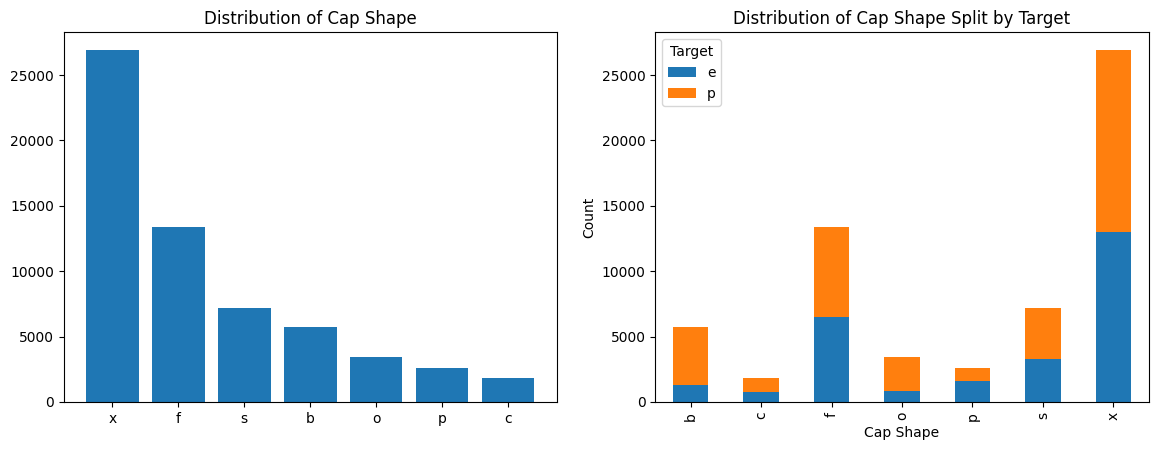

In [24]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(14)

vc = df['cap-shape'].value_counts()
axes[0].bar(x=vc.keys(), height=vc.values)
axes[0].set_title("Distribution of Cap Shape")

grouped = df.groupby(['cap-shape', target]).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, ax=axes[1])
plt.title('Distribution of Cap Shape Split by Target')
plt.xlabel('Cap Shape')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()

#### Cap Surface

According to data card:
Texture of the mushroom cap surface, where: fibrous (i) grooves (g) scaly (y) smooth (s) shiny (h) leathery (l) silky (k) sticky (t) wrinkled (w) fleshy (e)

We can observe that there are many different values for this variable. While there are some imbalances, it is only moderate at-worst compared to the slightly-severe imbalances of certain shape varieties.

There are some fairly-clear observations one can make from the cap-surface categories corresponding to target encodings:
* ```leathery``` (h) and ```shiny``` (s) caps tend to be slightly more edible than poisonous
* ```fibrous``` and ```silky``` varieties are almost all poisonous
* ```wringkled``` varieties tend to be disproportionately poisonous

It may be worth testing selecting only certain categories of encodings in ML model performance since encoding this variable will add quite a lot of dimensionality, and it's possible that only specific categories will add value to predictions.

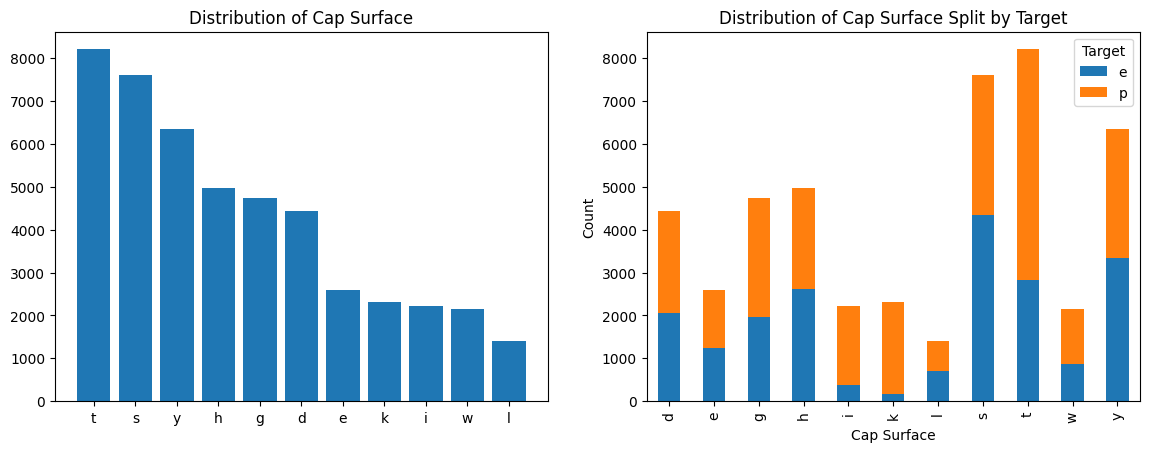

In [25]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(14)

vc = df['cap-surface'].value_counts()
axes[0].bar(x=vc.keys(), height=vc.values)
axes[0].set_title("Distribution of Cap Surface")

grouped = df.groupby(['cap-surface', target]).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, ax=axes[1])
plt.title('Distribution of Cap Surface Split by Target')
plt.xlabel('Cap Surface')
plt.ylabel('Count')
plt.legend(title='Target')
plt.show()

#### 🌈 Cap Color

According to the data card:

The color of the mushroom cap, with various options such as brown, buff, gray, green, pink, purple, red, white, yellow, blue, orange, and black (nominal).

Looks like most of the value in cap colors is held within the disproportionately-underrepresented categories. Also the data card fails to note how they are encoded.

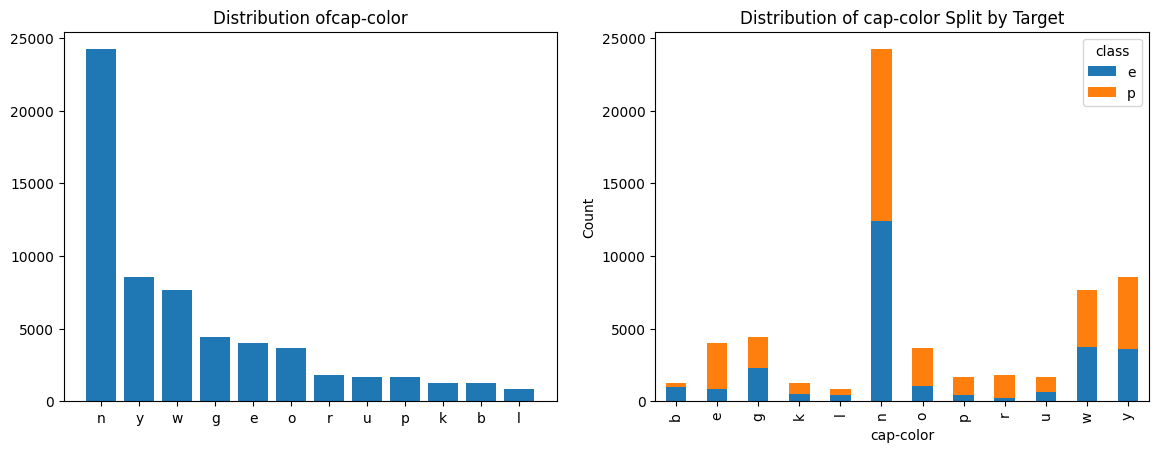

In [26]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(14)

col = 'cap-color'

vc = df[col].value_counts()
axes[0].bar(x=vc.keys(), height=vc.values)
axes[0].set_title("Distribution of"+col)

grouped = df.groupby([col, target]).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, ax=axes[1])
plt.title('Distribution of '+col+' Split by Target')
plt.xlabel(col)
plt.ylabel('Count')
plt.legend(title=target)
plt.show()

### Bruise or Bleed

This indicates whether the mushroom bruises or bleeds when injured

It looks like most mushrooms ```bruise```, and there isn't any immediate insights that the target distribution of the classes can bring.

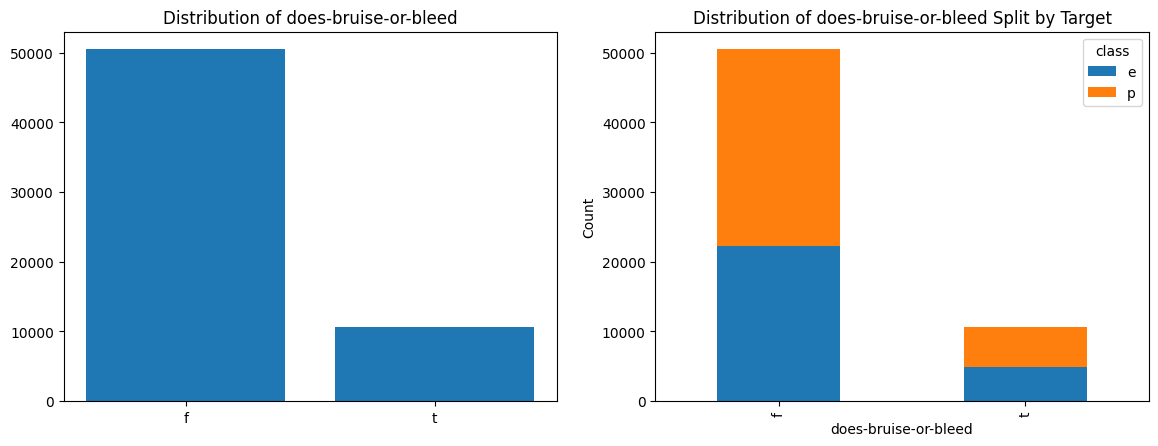

In [27]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(14)

col = 'does-bruise-or-bleed'

vc = df[col].value_counts()
axes[0].bar(x=vc.keys(), height=vc.values)
axes[0].set_title("Distribution of "+col)

grouped = df.groupby([col, target]).size().unstack(fill_value=0)
grouped.plot(kind='bar', stacked=True, ax=axes[1])
plt.title('Distribution of '+col+' Split by Target')
plt.xlabel(col)
plt.ylabel('Count')
plt.legend(title=target)
plt.show()

### Gill Features

#### Gill Attachment

The **Gill Attachment** has many different categories according to the data card:

How gills are attached to the stem, where: adnate (a) adnexed (x) decurrent (d) free (e) sinuate (s) pores (p) none (f) unknown (?)

The distribution of the variable, while not perfectly even, only has some **moderate** imbalances at worst.

The most interesting categories are:
* ```free``` (e) which tends to have more ```edible``` specimens
* ```pores``` (p) which tends to have more ```edible``` specimens

#### Gill Spacing

Gill Spacing has the following categories:
* ```Close``` (c)
* ```Distant``` (d)
* ```None``` (f)

We can see the vast majority of gill-spacing values are ```close```, which have a slightly higher proportion of ```poisonous``` specimens.

The minority class of ```distant```-gilled specimens tend to have a very strong correlation with being ```edible```.

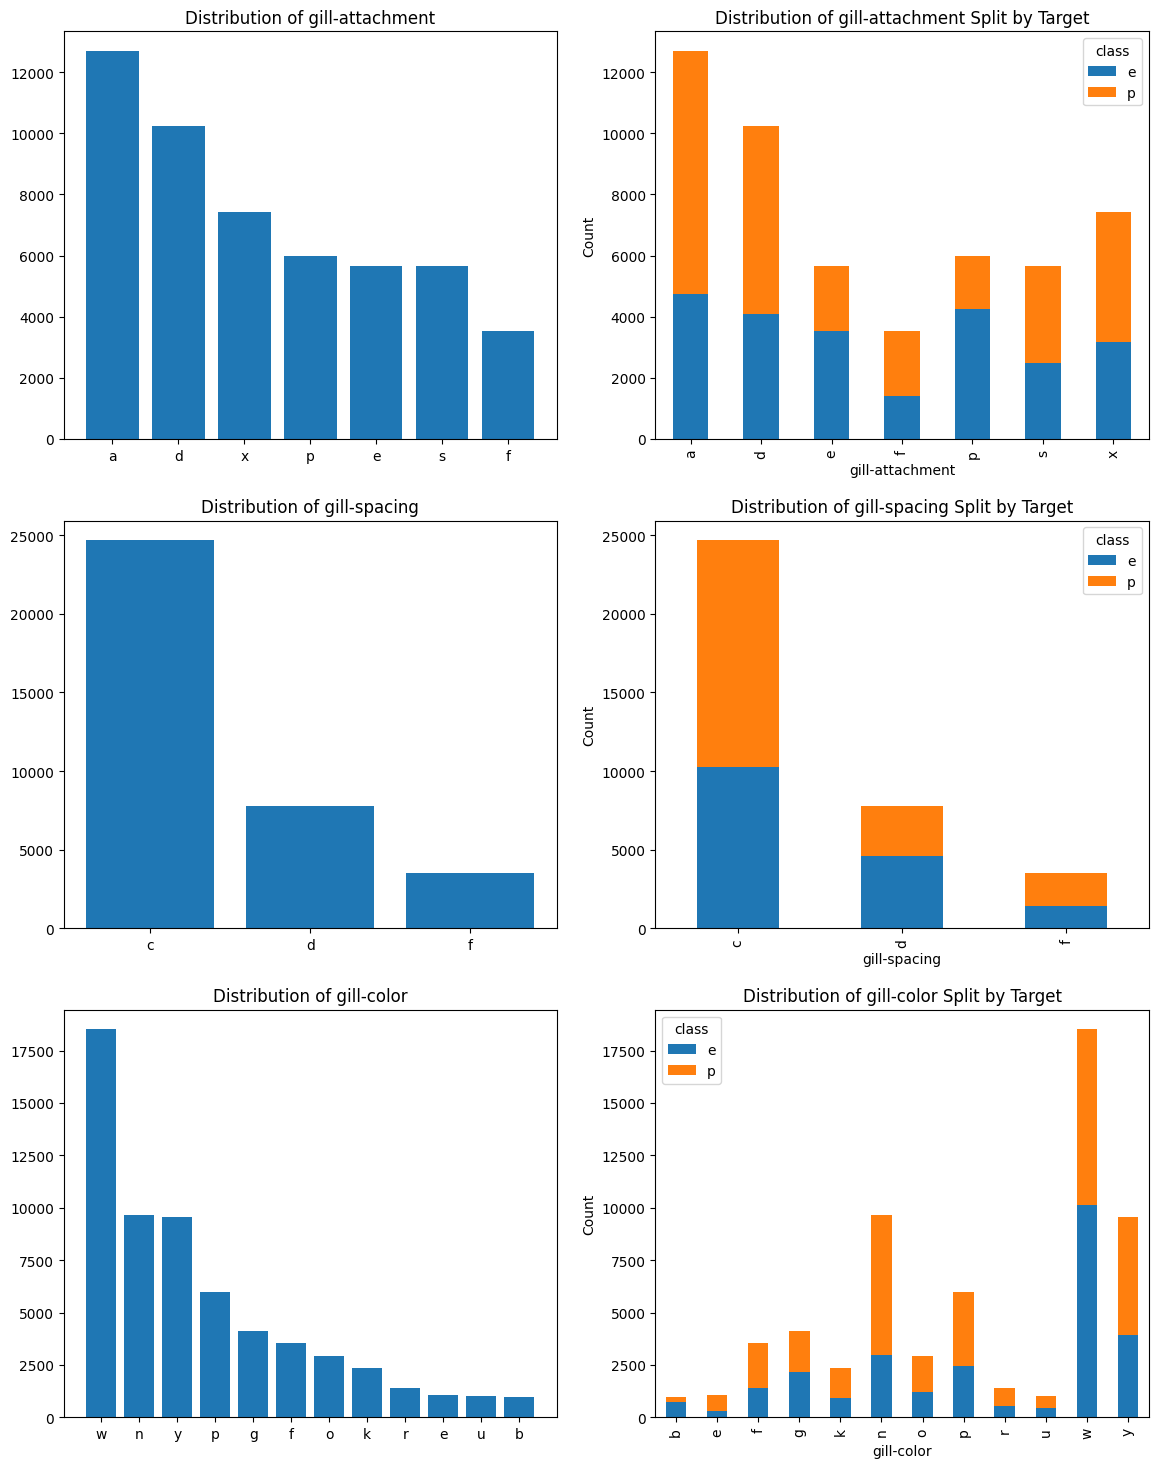

In [28]:
gill_features = ['gill-attachment', 'gill-spacing', 'gill-color']

fig, axes = plt.subplots(len(gill_features), 2)
fig.set_figheight(18)
fig.set_figwidth(14)

for i in range(len(gill_features)):
    col = gill_features[i]
    vc = df[col].value_counts()
    axes[i][0].bar(x=vc.keys(), height=vc.values)
    axes[i][0].set_title("Distribution of "+col)

    grouped = df.groupby([col, target]).size().unstack(fill_value=0)
    grouped.plot(kind='bar', stacked=True, ax=axes[i][1])
    axes[i][1].set_title("Distribution of "+col+" Split by Target")
    axes[i][1].set_xlabel(col)
    axes[i][1].set_ylabel('Count')
    axes[i][1].legend(title=target)

plt.show()

In [29]:

col = 'does-bruise-or-bleed'

# vc = df[col].value_counts()
# axes[0].bar(x=vc.keys(), height=vc.values)
# axes[0].set_title("Distribution of "+col)

# grouped = df.groupby([col, target]).size().unstack(fill_value=0)
# grouped.plot(kind='bar', stacked=True, ax=axes[1])
# plt.title('Distribution of '+col+' Split by Target')
# plt.xlabel(col)
# plt.ylabel('Count')
# plt.legend(title=target)
# plt.show()

### Stem Features

Both **Stem Width** and **Stem Height** exhibit the same outlier pattern of **Diameter**: outliers above a certain value are all of a certain class (in this case ```edible```). This will surely be of great value to machine learning models and great concern for the real-world application.

In fact, the categorical stem features also exhibit some scary signs as well - certain values are exclusively representative of singular classes.
* `c`, `f`, and `r` root values are exclusively `edible`
*  `f`, `g`, and `h` surface values are exclusively `edible`
* `f`, `p`, `i`, and `r` color values are exclusively `edible`

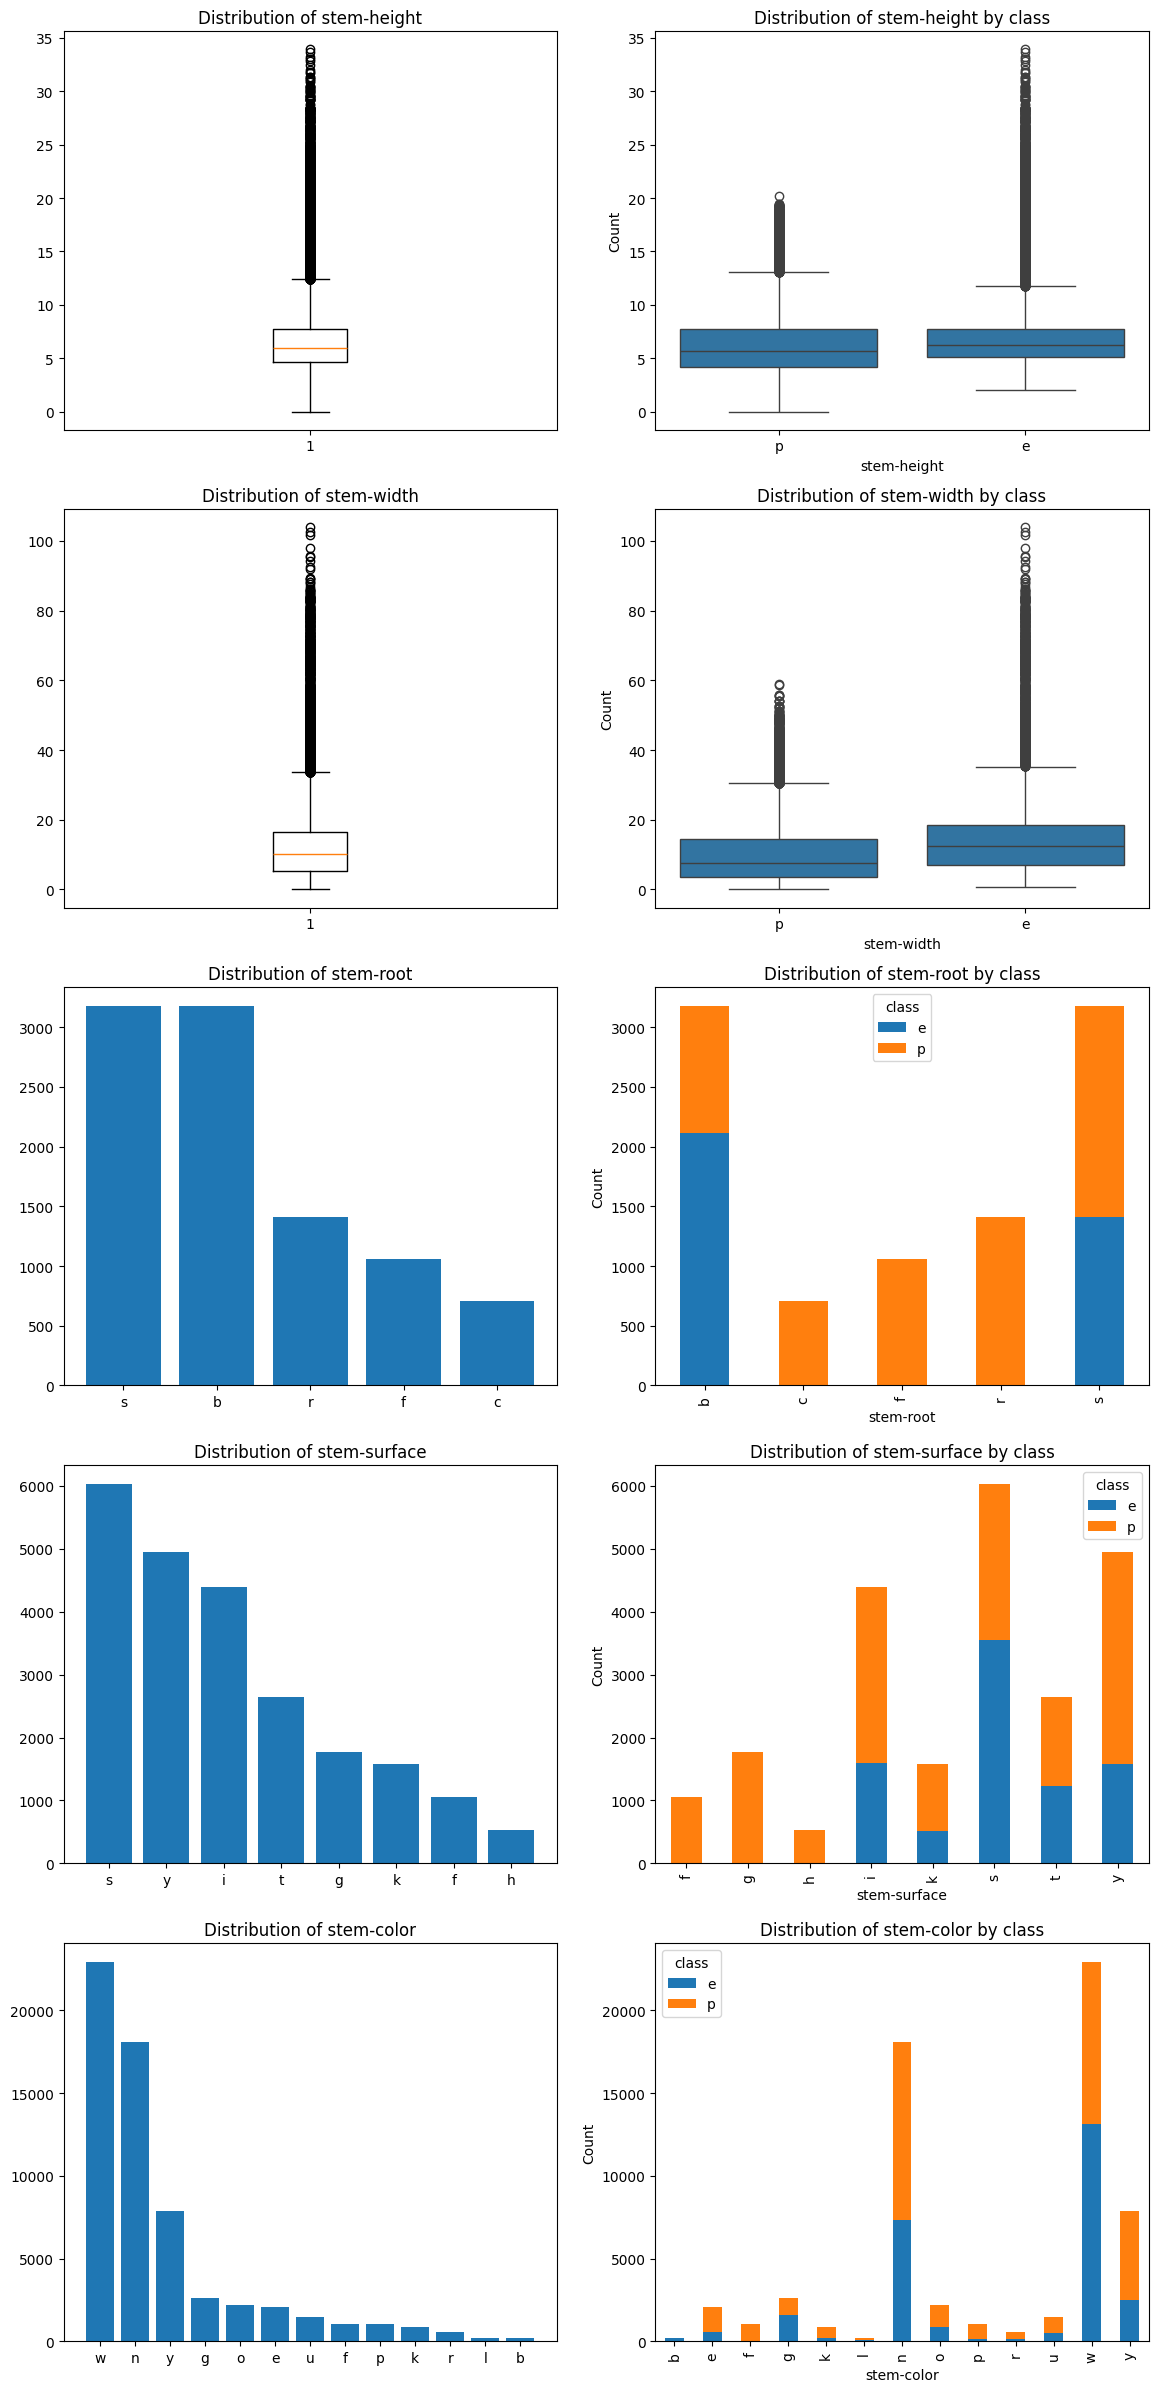

In [30]:
stem_features = ['stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color']

fig, axes = plt.subplots(len(stem_features), 2)
fig.set_figheight(6*len(stem_features))
fig.set_figwidth(14)

for i in range(len(stem_features)):
    col = stem_features[i]
    numeric_col = df[col].dtypes == 'float64'
    if numeric_col:
        axes[i][0].boxplot(df[col])
        sns.boxplot(data=df, x=target, y=col, ax=axes[i][1])
    else:
        vc = df[col].value_counts()
        axes[i][0].bar(x=vc.keys(), height=vc.values)
        grouped = df.groupby([col, target]).size().unstack(fill_value=0)
        grouped.plot(kind='bar', stacked=True, ax = axes[i][1])

    axes[i][0].set_title("Distribution of "+col)
    axes[i][1].set_title("Distribution of "+col+" by "+target)
    axes[i][1].set_xlabel(col)
    axes[i][1].set_ylabel('Count')

plt.show()

## 🧹 Cleaning Pipeline

Get the numerical and categorical features.

In [31]:
numeric = list(df.select_dtypes('float64').columns)
categorical = list(df.select_dtypes('object').drop(target, axis=1).columns)

numeric, categorical

(['cap-diameter', 'stem-height', 'stem-width'],
 ['cap-shape',
  'cap-surface',
  'cap-color',
  'does-bruise-or-bleed',
  'gill-attachment',
  'gill-spacing',
  'gill-color',
  'stem-root',
  'stem-surface',
  'stem-color',
  'veil-type',
  'veil-color',
  'has-ring',
  'ring-type',
  'spore-print-color',
  'habitat',
  'season'])

Create a pipeline function to process the target variable

In [32]:
def process_taret(df):
    ret = df.copy()
    if target in ret.columns:
        ret['poison'] = ret[target].apply(lambda x: 1 if x == 'p' else 0)
        ret = ret.drop(target, axis=1)
    return ret

The below function will encode all the specified categorical variables (in this case all the non-target `object` dtype).

In [33]:
def encode_categorical(df):
    if categorical[0] in df.columns:
        ret = df.copy()
        encoded = pd.get_dummies(ret[categorical])
        ret = pd.concat((ret, encoded), axis=1)
        ret = ret.drop(categorical, axis=1)
        return ret
    return df

The below function will perform normal scaling on all the specified numerical variables (in this case all the `int64` dtype).

In [34]:
def scale_numeric(df):
    ret = df.copy()
    for col in numeric:
        col_name = col + '_normal_scaled'
        ret[col_name] = (ret[col] - ret[col].mean()) / ret[col].std()
    return ret

In [35]:
def convert_bool_to_num(df):
    ret = df.copy()
    ret[ret.select_dtypes('bool').columns] = ret.select_dtypes('bool').astype(int)
    return ret

In [36]:
pipeline = [
    process_taret,
    encode_categorical,
    scale_numeric,
    convert_bool_to_num
]

df_clean = df.copy()

for i in pipeline:
    df_clean = i(df_clean)

df_clean.head()

,cap-diameter,stem-height,stem-width,cap_diam_big,poison,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,...,habitat_p,habitat_u,habitat_w,season_a,season_s,season_u,season_w,cap-diameter_normal_scaled,stem-height_normal_scaled,stem-width_normal_scaled
0,15.26,16.95,17.09,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1.619449,3.076679,0.492289
1,16.60,17.99,18.19,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1.873967,3.385283,0.601895
2,14.07,17.80,17.74,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1.393421,3.328904,0.557056
3,14.17,15.77,15.98,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,1.412415,2.726533,0.381687
4,14.64,16.53,17.20,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1.501686,2.952051,0.503250


## 🤔 Feature Selection

In [141]:
# df_clean.columns[24:]

Index(['cap-color_e', 'cap-color_g', 'cap-color_k', 'cap-color_l',
       'cap-color_n', 'cap-color_o', 'cap-color_p', 'cap-color_r',
       'cap-color_u', 'cap-color_w', 'cap-color_y', 'does-bruise-or-bleed_f',
       'does-bruise-or-bleed_t', 'gill-attachment_a', 'gill-attachment_d',
       'gill-attachment_e', 'gill-attachment_f', 'gill-attachment_p',
       'gill-attachment_s', 'gill-attachment_x', 'gill-spacing_c',
       'gill-spacing_d', 'gill-spacing_f', 'gill-color_b', 'gill-color_e',
       'gill-color_f', 'gill-color_g', 'gill-color_k', 'gill-color_n',
       'gill-color_o', 'gill-color_p', 'gill-color_r', 'gill-color_u',
       'gill-color_w', 'gill-color_y', 'stem-root_b', 'stem-root_c',
       'stem-root_f', 'stem-root_r', 'stem-root_s', 'stem-surface_f',
       'stem-surface_g', 'stem-surface_h', 'stem-surface_i', 'stem-surface_k',
       'stem-surface_s', 'stem-surface_t', 'stem-surface_y', 'stem-color_b',
       'stem-color_e', 'stem-color_f', 'stem-color_g', 'stem-col

In [172]:
features = [
    'cap-diameter',
    'stem-height',
    'stem-width',
  
    'cap-shape_b',
    'cap-shape_c',
    'cap-shape_f',
    'cap-shape_o',
    'cap-shape_p',
    'cap-shape_s',
    'cap-shape_x',
  
    'cap-surface_d',
    'cap-surface_e',
    'cap-surface_g',
    'cap-surface_h',
    'cap-surface_i',
    'cap-surface_k',
    'cap-surface_l',
    'cap-surface_s',
    'cap-surface_t',
    'cap-surface_w',
    'cap-surface_y',
    
    # 'cap-color_b',
    # 'cap-color_e',
    # 'cap-color_g',
    # 'cap-color_k',
    # 'cap-color_l',
    # 'cap-color_n',
    # 'cap-color_o',
    # 'cap-color_p',
    # 'cap-color_r',
    # 'cap-color_u',
    # 'cap-color_w',
    # 'cap-color_y',
    
    'does-bruise-or-bleed_f',
    'does-bruise-or-bleed_t',
    
    'gill-attachment_a',
    'gill-attachment_d',
    'gill-attachment_e',
    'gill-attachment_f',
    'gill-attachment_p',
    'gill-attachment_s',
    'gill-attachment_x',
    
    'gill-spacing_c',
    'gill-spacing_d',
    'gill-spacing_f',
    
    # 'gill-color_b',
    # 'gill-color_e',
    # 'gill-color_f',
    # 'gill-color_g',
    # 'gill-color_k',
    # 'gill-color_n',
    # 'gill-color_o',
    # 'gill-color_p',
    # 'gill-color_r',
    # 'gill-color_u',
    # 'gill-color_w',
    # 'gill-color_y',
    
    # 'stem-root_b',
    # 'stem-root_c',
    # 'stem-root_f',
    # 'stem-root_r',
    # 'stem-root_s',
    
    # 'stem-surface_f',
    # 'stem-surface_g',
    # 'stem-surface_h',
    # 'stem-surface_i',
    # 'stem-surface_k',
    # 'stem-surface_s',
    # 'stem-surface_t',
    # 'stem-surface_y',
    
    # 'stem-color_b',
    # 'stem-color_e',
    # 'stem-color_f',
    # 'stem-color_g',
    # 'stem-color_k',
    # 'stem-color_l',
    # 'stem-color_n',
    # 'stem-color_o',
    # 'stem-color_p',
    # 'stem-color_r',
    # 'stem-color_u',
    # 'stem-color_w',
    # 'stem-color_y',
    
    'veil-type_u',
    
    # 'veil-color_e',
    # 'veil-color_k',
    # 'veil-color_n',
    # 'veil-color_u',
    # 'veil-color_w',
    # 'veil-color_y',
    
    'has-ring_f',
    'has-ring_t',
    
    'ring-type_e',
    'ring-type_f',
    'ring-type_g',
    'ring-type_l',
    'ring-type_m',
    'ring-type_p',
    'ring-type_r',
    'ring-type_z',
    
    # 'spore-print-color_g',
    # 'spore-print-color_k',
    # 'spore-print-color_n',
    # 'spore-print-color_p',
    # 'spore-print-color_r',
    # 'spore-print-color_u',
    # 'spore-print-color_w',
    
    'habitat_d',
    'habitat_g',
    'habitat_h',
    'habitat_l',
    'habitat_m',
    'habitat_p',
    'habitat_u',
    'habitat_w',

    'season_a',
    'season_s',
    'season_u',
    'season_w',

]

In [173]:
# For the moment we keep them all
y_var = 'poison'
# features = list(df_clean.drop(y_var, axis=1).columns)

## Splitting

Test Set - since this isn't a kaggle competiton (it's just a dataset), we will manually be setting aside 10% of the data for testing before doing a validation split.

In [174]:
num_test = len(df_clean)//10

df_train = df_clean[:-num_test]
df_test = df_clean[-num_test:]

# Shouldn't be any union, shouldn't be any data entries left-out
assert(len(df_train) + len(df_test) == len(df_clean))
len(df_clean), len(df_train), len(df_test)

(61069, 54963, 6106)

In [175]:
from sklearn.model_selection import train_test_split

# Call a test-train split on the training data, organize the features and the dependent variable of the testing data
X_train, X_valid, y_train, y_valid = train_test_split(df_train[features], df_train[y_var], test_size=0.2, random_state=42)
X_test, y_test = df_test[features], df_test[y_var]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, X_test.shape, y_test.shape

((43970, 56), (10993, 56), (43970,), (10993,), (6106, 56), (6106,))

## 🤖 Machine Learning

### Logistic Regression

Baseline 5 folds: 0.873895640783058

In [40]:
num_folds = 5
lr_scores = []

for i in range(num_folds):
    x_train_fold, x_valid_fold, y_train_fold, y_valid_fold= train_test_split(df_train[features], df_train[y_var], random_state=i)
    lr = LogisticRegression(max_iter=1500)
    lr.fit(x_train_fold, y_train_fold)
    lr_pred_fold = lr.predict(x_valid_fold)
    lr_scores.append(accuracy_score(y_valid_fold, lr_pred_fold))

np.array(lr_scores).mean()

0.873895640783058

Baseline model: 0.8691894842172292

In [41]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_valid)

accuracy_score(y_valid, lr_pred)

0.8691894842172292

### Custom KNN

Function kNN_Classify(X_train, y_train, X_test, k):
    Initialize an empty list to store predictions

    For each test point in X_test:
        Calculate the distance from the test point to all training points in X_train
        Sort the distances in ascending order and retain the indices of the sorted distances
        Select the indices of the k smallest distances to find the k nearest neighbors

        Gather the labels of these k nearest neighbors from y_train
        Count the number of occurrences of each class label among the k nearest neighbors
        Predict the class label that appears most frequently among the k nearest neighbors

        Append the predicted class label to the list of predictions

    Return the list of predictions


In [257]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled_train, X_scaled_test = X_train.copy(), X_test.copy()
X_scaled_train[X_scaled_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_scaled_test[X_scaled_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [246]:
class KNN_classifier_custom():

    # Default value of k is 3
    def __init__(self, k = 3) -> None:
        self.k = k

    def predict(self, X_train, y, X_test, iter_k = False):
        # Initialize empty predictions array
        if iter_k == True:
            # preds = np.zeros((len(X_test), len(X_train)))
            preds = []
        else:
            preds = np.zeros(len(X_test))

        for i in range(len(X_test)):
            # Initialize empty distances array, then compute distances from test point to each training point
            distances = np.zeros(len(X_train))
            distances = np.sqrt(sum((X_test.iloc[i].values - X_train.values) ** 2))
            print(i, len(X_test))
            # for j in range(len(X_train)):
                # x = np.sqrt(sum((X_test.iloc[i].values - X_train.iloc[j].values) ** 2))
                # print(i, '/', len(X_test), j, '/', len(X_train), x)
                # distances[j] = np.sqrt(sum((X_test.iloc[i].values - X_train.iloc[j].values) ** 2))

            sorted_distance_indices = np.argsort(distances)
            # For now it will just work with a single column in the validation dataframe
            if iter_k:
                preds.append(sorted_distance_indices)
            else:
                preds[i] = y.iloc[sorted_distance_indices[:self.k]].mode().values[0]

        return preds
        # return distances
            # distances.sort()

knn = KNN_classifier_custom()
preds_knn = knn.predict(X_scaled_train, y_train, X_scaled_test)

0 6106
1 6106
2 6106
3 6106
4 6106
5 6106
6 6106
7 6106
8 6106
9 6106
10 6106
11 6106
12 6106
13 6106
14 6106
15 6106
16 6106
17 6106
18 6106
19 6106
20 6106
21 6106
22 6106
23 6106
24 6106
25 6106
26 6106
27 6106
28 6106
29 6106
30 6106
31 6106
32 6106
33 6106
34 6106
35 6106
36 6106
37 6106
38 6106
39 6106
40 6106
41 6106
42 6106
43 6106
44 6106
45 6106
46 6106
47 6106
48 6106
49 6106
50 6106
51 6106
52 6106
53 6106
54 6106
55 6106
56 6106
57 6106
58 6106
59 6106
60 6106
61 6106
62 6106
63 6106
64 6106
65 6106
66 6106
67 6106
68 6106
69 6106
70 6106
71 6106
72 6106
73 6106
74 6106
75 6106
76 6106
77 6106
78 6106
79 6106
80 6106
81 6106
82 6106
83 6106
84 6106
85 6106
86 6106
87 6106
88 6106
89 6106
90 6106
91 6106
92 6106
93 6106
94 6106
95 6106
96 6106
97 6106
98 6106
99 6106
100 6106
101 6106
102 6106
103 6106
104 6106
105 6106
106 6106
107 6106
108 6106
109 6106
110 6106
111 6106
112 6106
113 6106
114 6106
115 6106
116 6106
117 6106
118 6106
119 6106
120 6106
121 6106
122 6106
123

In [258]:
scores = []

for i in range(10):
    knn_temp = KNN_classifier_custom(k=i)
    scores.append(knn.predict(X_scaled_train, y_train, X_scaled_test))
    # print(y_valid.iloc[preds_knn[i][]])
    # score = y_valid.iloc[preds_knn[[i][:i]]].mode()

scores

0 6106
1 6106
2 6106
3 6106
4 6106
5 6106
6 6106
7 6106
8 6106
9 6106
10 6106
11 6106
12 6106
13 6106
14 6106
15 6106
16 6106
17 6106
18 6106
19 6106
20 6106
21 6106
22 6106
23 6106
24 6106
25 6106
26 6106
27 6106
28 6106
29 6106
30 6106
31 6106
32 6106
33 6106
34 6106
35 6106
36 6106
37 6106
38 6106
39 6106
40 6106
41 6106
42 6106
43 6106
44 6106
45 6106
46 6106
47 6106
48 6106
49 6106
50 6106
51 6106
52 6106
53 6106
54 6106
55 6106
56 6106
57 6106
58 6106
59 6106
60 6106
61 6106
62 6106
63 6106
64 6106
65 6106
66 6106
67 6106
68 6106
69 6106
70 6106
71 6106
72 6106
73 6106
74 6106
75 6106
76 6106
77 6106
78 6106
79 6106
80 6106
81 6106
82 6106
83 6106
84 6106
85 6106
86 6106
87 6106
88 6106
89 6106
90 6106
91 6106
92 6106
93 6106
94 6106
95 6106
96 6106
97 6106
98 6106
99 6106
100 6106
101 6106
102 6106
103 6106
104 6106
105 6106
106 6106
107 6106
108 6106
109 6106
110 6106
111 6106
112 6106
113 6106
114 6106
115 6106
116 6106
117 6106
118 6106
119 6106
120 6106
121 6106
122 6106
123

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [260]:
for i in scores:
    print(accuracy_score(y_test, i))

0.6604978709466099
0.6604978709466099
0.6604978709466099
0.6604978709466099
0.6604978709466099
0.6604978709466099
0.6604978709466099
0.6604978709466099
0.6604978709466099
0.6604978709466099
